In [4]:
from pathlib import Path
desktop_path = Path.home() / "Desktop"
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, rf'{desktop_path}\RA\penicilin\Libaries')

import main as m


In [5]:
import pandas as pd
import bw2data as bd
import warnings
import bw2data as bd
import brightway2 as bw
import bw2calc as bc
import numpy as np
from uuid import uuid4
import sensitvity_countries as stc


In [6]:
init = m.main()
bw.databases

Databases dictionary with 12 object(s):
	biosphere3
	countries sensitivity
	ev391consq
	ev391cutoff
	penicillin_consq
	penicillin_cut_off_CH
	penicillin_cut_off_CN
	penicillin_cut_off_DK
	penicillin_cut_off_IN
	penicillin_cut_off_IT
	penicillin_cut_off_US
	test

In [4]:
init.bw_project

'Penicillin'

In [6]:
db = init.db

activity = db.random()
activity

C:\Users\ruw\AppData\Roaming\Python\Python311\site-packages\bw2data\backends\peewee\database.py:127: UserWarning: This database is empty
  warnings.warn("This database is empty")


In [9]:
init.database_setup(reload=True, sensitivty=True)

Extracted 1 worksheets in 0.05 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 3.34 seconds
Matching database: ev391cutoff
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


33 datasets
279 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_IN-unlinked.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:13
  Finished: 09/26/2025 10:54:13
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 2.27
Created database: penicillin_cut_off_IN
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_lis

Writing activities to SQLite3 database:


22 datasets
195 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_CN-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:18
  Finished: 09/26/2025 10:54:18
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 2.26
Created database: penicillin_cut_off_CN
Extracted 1 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_lis

Writing activities to SQLite3 database:


22 datasets
195 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_CN-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:23
  Finished: 09/26/2025 10:54:23
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 2.32
Created database: penicillin_cut_off_CN
Extracted 1 worksheets in 0.07 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list

Writing activities to SQLite3 database:


22 datasets
194 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_IT-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:28
  Finished: 09/26/2025 10:54:28
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 2.26
Created database: penicillin_cut_off_IT
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list

Writing activities to SQLite3 database:


22 datasets
194 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_IT-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:33
  Finished: 09/26/2025 10:54:33
  Total time elapsed: 00:00:00
  CPU %: 50.40
  Memory %: 2.30
Created database: penicillin_cut_off_IT
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_lis

Writing activities to SQLite3 database:


22 datasets
194 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_CH-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:38
  Finished: 09/26/2025 10:54:38
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 2.33
Created database: penicillin_cut_off_CH
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list

Writing activities to SQLite3 database:


22 datasets
194 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_CH-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:43
  Finished: 09/26/2025 10:54:43
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 2.29
Created database: penicillin_cut_off_CH
Extracted 1 worksheets in 0.05 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list

Writing activities to SQLite3 database:


22 datasets
196 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_US-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:48
  Finished: 09/26/2025 10:54:48
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 2.29
Created database: penicillin_cut_off_US
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_lis

Writing activities to SQLite3 database:


22 datasets
196 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_US-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:54
  Finished: 09/26/2025 10:54:54
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 2.35
Created database: penicillin_cut_off_US
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_li

Writing activities to SQLite3 database:


22 datasets
194 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_DK-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:54:59
  Finished: 09/26/2025 10:54:59
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 2.30
Created database: penicillin_cut_off_DK
Extracted 1 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_li

Writing activities to SQLite3 database:


22 datasets
194 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_DK-unlinked.xlsx


0% [######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/26/2025 10:55:04
  Finished: 09/26/2025 10:55:04
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 2.33
Created database: penicillin_cut_off_DK


In [9]:
del bw.databases['countries sensitivity']
bw.databases

Databases dictionary with 5 object(s):
	biosphere3
	ev391consq
	ev391cutoff
	penicillin_consq
	test

In [7]:
countries_sensitivity_database = "countries sensitivity"

if countries_sensitivity_database not in bw.databases:
    bw.Database(countries_sensitivity_database).write({})  # registers an empty database
countries_db = bw.Database(countries_sensitivity_database)
bw.databases

Databases dictionary with 12 object(s):
	biosphere3
	countries sensitivity
	ev391consq
	ev391cutoff
	penicillin_consq
	penicillin_cut_off_CH
	penicillin_cut_off_CN
	penicillin_cut_off_DK
	penicillin_cut_off_IN
	penicillin_cut_off_IT
	penicillin_cut_off_US
	test

In [8]:
databases_lst = [db for db in bw.databases if "cut_off" in db]
databases_lst.sort()
databases_lst

['penicillin_cut_off_CH',
 'penicillin_cut_off_CN',
 'penicillin_cut_off_DK',
 'penicillin_cut_off_IN',
 'penicillin_cut_off_IT',
 'penicillin_cut_off_US']

In [5]:
for db in databases_lst:
    del bw.databases[db]
bw.databases

Databases dictionary with 5 object(s):
	biosphere3
	ev391consq
	ev391cutoff
	penicillin_consq
	test

In [9]:
countries_sensitivity_database = "countries sensitivity"

if countries_sensitivity_database not in bw.databases:
    bw.Database(countries_sensitivity_database).write({})  # registers an empty database
    print(f"countries_sensitivity_database is created")
countries_db = bw.Database(countries_sensitivity_database)

db_to_extract = {}

for db_str in databases_lst:
    src_db = bw.Database(db_str)

    # Map of names to codes for activities whose name contains "defined system"
    db_to_extract[src_db.name] = {
        a.get("name"): a.get("code")
        for a in src_db
        if "defined system" in (a.get("name") or "")
    }

    for src in src_db:
        name = src.get("name")
        location = src.get("database")[-2:]
        name_loc = fr"{name}_{location}"
        if "defined system" not in (name or ""):
            continue

        if name_loc not in [act['name'] for act in countries_db]:
            print(f"{name_loc} not in {countries_db.name}")
            # Create the new activity in the target DB
            new = countries_db.new_activity(
                code=uuid4().hex,
                name=name_loc,
                unit=src.get("unit"),
                location=src.get("location"),
                type="process",  # <-- FIX: node type, not exchange type
                **{"reference product": src.get("reference product")},
            )
            new.save()

            # Optional but recommended: add an explicit production exchange
            new.new_exchange(
                input=new.key,
                amount=src.get("production amount", 1),
                type="production",
            ).save()

            # Optional: copy technosphere & biosphere exchanges
            # (skip production; keep original inputs)
            for exc in src.exchanges():
                if exc["type"] == "production":
                    continue
                new.new_exchange(
                    input=exc.input.key,
                    amount=exc["amount"],
                    type=exc["type"],
                ).save()
        else:
            print(f"{name_loc} is in {countries_db.name}")


Penicillin V, defined system_CH is in countries sensitivity
Penicillin G, defined system_CH is in countries sensitivity
Penicillin V, defined system_CN is in countries sensitivity
Penicillin G, defined system_CN is in countries sensitivity
Penicillin V, defined system_DK is in countries sensitivity
Penicillin G, defined system_DK is in countries sensitivity
Penicillin G, defined system_IN is in countries sensitivity
Penicillin V, defined system_IN is in countries sensitivity
Penicillin V, defined system_IT is in countries sensitivity
Penicillin G, defined system_IT is in countries sensitivity
Penicillin G, defined system_US is in countries sensitivity
Penicillin V, defined system_US is in countries sensitivity


In [144]:
pen_type =  ["G", "V"]
country_order = {
    "IN" : "India",
    "CN" : "China",
    "IT" : "Italy",
    "CH" : "Switzerland",
    "US" : "USA",
    "DK" : "Denmark"
}

In [232]:
def append_func_unit(act, exc, act_check, func_unit_unq, func_unit_countries, upstream_quantity=1):
    if "defined system" not in str(exc.input):
        if str(exc.input) not in act_check:
            func_unit_unq.append({exc.input :1})
            act_check.append(str(exc.input))
        func_unit_countries[act].update({str(exc.input) : exc['amount']*upstream_quantity})

def is_raw_penicillin(db_act, pen):
    return "raw" in db_act["name"] and pen in db_act["name"]

def is_same_country(db_str, country_code, country_ISO, pen, exc):
    return db_str[-2:] == country_code and db_str[-2:] == country_ISO and pen in exc.input["name"]

def get_country_code(exc):
    return exc.input["name"][-2:]

def extract_activity_raw_penicillin(act, db_act, act_check, func_unit_unq, func_unit_countries):
    for up in db_act.upstream():
        if up.output != db_act:
            upstream_quantity = up["amount"]
    for db_act in db_act.exchanges():
        # print(db_act.input)
        if "elec" in db_act["name"] or "production" in db_act["type"]:
            append_func_unit(act, db_act, act_check, func_unit_unq, func_unit_countries, upstream_quantity=upstream_quantity)

def is_penicillin_V(exc):
    return "V" in exc.input["name"]

def extract_activity_penicillin_V(act, db_act, act_check, func_unit_unq, func_unit_countries):
    if "production of a medicine strip" in db_act["name"]:
        for vexc in db_act.exchanges():
            if "strip" in vexc["name"] or "tablet" in vexc["name"] or "secondary" in vexc["name"]:
                for vup in db_act.upstream():
                    upstream_quantity = vup["amount"]
                    # append_func_unit(exc, act_check, func_unit_unq, func_unit_countries)
                append_func_unit(act, vexc, act_check, func_unit_unq, func_unit_countries, upstream_quantity= upstream_quantity/vexc["amount"])

def is_glass_vial_production(db_act):
    return "production of glass vial" in db_act["name"]

def extract_activity_glass_vial_production(act, db_act, act_check, func_unit_unq, func_unit_countries):
    for gv_exc in db_act.exchanges():
        if gv_exc["type"] == "production":
            append_func_unit(act, gv_exc, act_check, func_unit_unq, func_unit_countries)
            # for up in gv_exc.input.upstream():
            #     print(up)

def is_transport(db_act, pen):
    
    if "V" in pen:
        return "forming foil" in db_act["name"] or "lidding foil" in db_act["name"] or "secondary packaging" in db_act["name"] 
    else:
        return "packaging of glass vials with penicillin G" in db_act["name"]

def is_IV_or_oral(pen):
    if "V" in pen:
        return 20
    else:
        return 10

def extract_activity_transport(act, db_act, act_check, func_unit_unq, func_unit_countries, pen):
    for trans_exc in db_act.exchanges():
        if "transport" in trans_exc.input["name"]:
            for up in db_act.upstream():
                upstream_quantity = up["amount"]
            upstream_quantity_scaling = upstream_quantity / is_IV_or_oral(pen)

            append_func_unit(act, trans_exc, act_check, func_unit_unq, func_unit_countries, 
                             upstream_quantity=upstream_quantity_scaling)
            
def is_box_of_vials(db_act, pen):
    return "G" in pen and "packaging of glass vials with penicillin G" in db_act["name"]

def extract_production_amounts(act, pen, country_ISO, act_check, func_unit_unq, func_unit_countries):
    for exc in act.exchanges():
        country_code = get_country_code(exc)
        for db_str in databases_lst:
            if is_same_country(db_str, country_code, country_ISO, pen, exc):
                db = bw.Database(db_str)
                for db_act in db:
                    if is_raw_penicillin(db_act, pen):
                        extract_activity_raw_penicillin(act, db_act, act_check, func_unit_unq, func_unit_countries)
                    
                    elif is_glass_vial_production(db_act):
                        extract_activity_glass_vial_production(act, db_act, act_check, func_unit_unq, func_unit_countries)

                    elif is_transport(db_act, pen):
                        extract_activity_transport(act, db_act, act_check, func_unit_unq, func_unit_countries, pen)
                    
                    elif is_penicillin_V(exc):
                        extract_activity_penicillin_V(act, db_act, act_check, func_unit_unq, func_unit_countries)

                    if is_box_of_vials(db_act, pen):
                        for exc in db_act.exchanges():
                            if exc['type'] == 'production':
                                exc_act = exc
                        for up in db_act.upstream():
                            amount = up["amount"]
                        append_func_unit(act, exc_act, act_check, func_unit_unq, func_unit_countries, upstream_quantity=amount)
                    

def fill_penicillin_dct_keys(pen_type):
    func_unit_countries =  {}
    for pt in pen_type:
        for act in countries_db:
            if f"Penicillin {pt}" in str(act['name']) and "defined system" in str(act['name']):
                func_unit_countries[act] = {}
    return func_unit_countries

def is_pen_and_country_ISO(pen, act, country_ISO):
    return pen in act["name"] and country_ISO in act["name"]

def is_technosphere(exc):
    return exc['type'] == 'technosphere' and "packaging of glass vials" not in str(exc.input)

def is_act_type_process(act):
    return act["type"] == "process"

def func_unit_to_dataframe(func_unit_countries):
    df = pd.DataFrame(func_unit_countries)

    new_cols = []
    for pen in pen_type: 
        for iso in country_order.keys():
            matching_cols = [col for col in df.columns if (iso in col["name"] and pen in col["name"])]
            if matching_cols:
                new_cols.append(matching_cols[0])

    df_new = pd.DataFrame(0, index=df.index, columns=new_cols, dtype=object)

    for col in df_new.columns:
        df_new[col] = df[col]
    
    return df_new

def get_functional_unit_and_unique_activities(pen_type, country_order):
    act_check = []
    func_unit_unq = []
    func_unit_countries = fill_penicillin_dct_keys(pen_type)
    for pen in pen_type:
        for country_ISO in country_order.keys():
            for act in countries_db:
                if is_pen_and_country_ISO(pen, act, country_ISO):
                    for exc in act.exchanges():
                        if is_technosphere(exc):
                            append_func_unit(act, exc, act_check, func_unit_unq, func_unit_countries)
                if is_act_type_process(act):
                    extract_production_amounts(act, pen, country_ISO, act_check, func_unit_unq, func_unit_countries)
    
    print(f"Found {len(func_unit_unq)} unique activites")

    df = func_unit_to_dataframe(func_unit_countries)

    # Precompute a lookup dict: {key: fu_dict}
    lookup = {str(list(fu.keys())[0]): fu for fu in func_unit_unq}
    
    # Build the sorted list in one pass
    func_unit_unq_sorted = [lookup[idx] for idx in df.index if idx in lookup]
    # df_new.columns = [col["name"] for col in df_new.columns]

    return df, func_unit_unq_sorted

In [233]:
df_fu, func_unit_unq = get_functional_unit_and_unique_activities(pen_type, country_order)
df_fu


Found 63 unique activites


,"[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]"
"'production of alchohol wipes' (unit, RER, None)",1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
"'production of a pair of gloves' (unit, MY, None)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
"'treatment of hazardous waste, hazardous waste incineration, with energy recovery' (kilogram, CH, None)",-0.082795,-0.082795,-0.082795,-0.082795,-0.082795,-0.082795,NaN,NaN,NaN,NaN,NaN,NaN
"'production of IV bag' (unit, RER, None)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
"'medical connector' (unit, GLO, None)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
"'manufacturing of raw penicillium V' (kilogram, DK, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00066
"'production of a medicine strip' (unit, IN, None)",NaN,NaN,NaN,NaN,NaN,NaN,0.05000,NaN,NaN,NaN,NaN,NaN
"'manufacturing of raw penicillium V' (kilogram, IN, None)",NaN,NaN,NaN,NaN,NaN,NaN,0.00066,NaN,NaN,NaN,NaN,NaN
"'secondary packaging production' (unit, IN, None)",NaN,NaN,NaN,NaN,NaN,NaN,0.05000,NaN,NaN,NaN,NaN,NaN


In [234]:
ics = init.lcia_impact_method()                
# Set up and perform the LCA calculation
bd.calculation_setups["countries"] = {'inv': func_unit_unq, 'ia': [ics[1]]}
    
mylca = bc.MultiLCA("countries")
res = mylca.results

In [235]:
df_gwp = df_fu * res
df_gwp

,"[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]","[database, code, location, name, unit, type, reference product]"
"'production of alchohol wipes' (unit, RER, None)",0.002030,NaN,0.002030,0.002030,0.002030,0.002030,NaN,NaN,NaN,NaN,NaN,NaN
"'production of a pair of gloves' (unit, MY, None)",0.146823,0.146823,0.146823,0.146823,0.146823,0.146823,NaN,NaN,NaN,NaN,NaN,NaN
"'treatment of hazardous waste, hazardous waste incineration, with energy recovery' (kilogram, CH, None)",0.205445,0.205445,0.205445,0.205445,0.205445,0.205445,NaN,NaN,NaN,NaN,NaN,NaN
"'production of IV bag' (unit, RER, None)",0.202636,0.202636,0.202636,0.202636,0.202636,0.202636,NaN,NaN,NaN,NaN,NaN,NaN
"'medical connector' (unit, GLO, None)",0.111410,0.111410,0.111410,0.111410,0.111410,0.111410,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
"'manufacturing of raw penicillium V' (kilogram, DK, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018453
"'production of a medicine strip' (unit, IN, None)",NaN,NaN,NaN,NaN,NaN,NaN,0.045629,NaN,NaN,NaN,NaN,NaN
"'manufacturing of raw penicillium V' (kilogram, IN, None)",NaN,NaN,NaN,NaN,NaN,NaN,0.039882,NaN,NaN,NaN,NaN,NaN
"'secondary packaging production' (unit, IN, None)",NaN,NaN,NaN,NaN,NaN,NaN,0.002789,NaN,NaN,NaN,NaN,NaN


In [236]:
def category_sorting():
    pen_contries_cat_dct = {
    "Penicillin manufacturing": ["raw penicillium"],
    "Penicillin packaging" : ["strip", "vial", "secondary"],
    "Electricity": ["electricity"],
    "Transport" : ["transport"],
    "Auxilary product": ["wipe", "glove", "stopcock", "water", "sodium", " connector", "IV", "medicin cup"],
    "Disposal": ["waste"]
    }

    return pen_contries_cat_dct

pen_contries_cat_dct = category_sorting()

In [316]:
a = df_gwp.columns
a[0]["name"]

'Penicillin G, defined system_IN'

In [190]:
df_gwp.columns = [col["name"] for col in df_gwp.columns]
df_gwp.columns


Index(['Penicillin G, defined system_DK', 'Penicillin G, defined system_CH',
       'Penicillin G, defined system_US', 'Penicillin G, defined system_CN',
       'Penicillin G, defined system_IT', 'Penicillin G, defined system_IN',
       'Penicillin V, defined system_CN', 'Penicillin V, defined system_US',
       'Penicillin V, defined system_IT', 'Penicillin V, defined system_CH',
       'Penicillin V, defined system_IN', 'Penicillin V, defined system_DK'],
      dtype='object')

In [237]:
pen_contries_cat_dct = {
    "P. manufacturing": ["raw penicillium"],
    "P. packaging" : ["strip", "vial", "secondary"],
    "P. Electricity": ["electricity"],
    "Transport" : ["transport"],
    "Auxilary prod.": ["wipe", "glove", "stopcock", "water", "sodium", " connector", "IV", "medicin cup"],
    "Disposal": ["waste"]
    }

In [238]:
value_correction_dct = {
    "strip" : ["tablet", "secondary", "transport"],
    "glass vials with" :["raw", "production of glass vial"],
    "tablet" : ["raw"],
    "raw pen" : ["elec"],
}

In [239]:
df_gwp = df_fu * res
df_gwp.columns = [col["name"] for col in df_gwp.columns]

for col in df_gwp.columns:
    df_temp = df_gwp[col].dropna().to_frame()
    for key, item in value_correction_dct.items():
        idx_key = [idx for idx in df_temp.index if key in str(idx)]
        idx_item = [idx for idx in df_temp.index if any(i in str(idx) for i in item)]
        if idx_key and idx_item:

            val = df_temp.loc[idx_item].sum()

            df_gwp.loc[idx_key, col] -= val.sum()
            
df_temp = df_gwp.T.iloc[0].dropna().to_frame()
df_temp

,"Penicillin G, defined system_IN"
"'production of alchohol wipes' (unit, RER, None)",0.002030
"'production of a pair of gloves' (unit, MY, None)",0.146823
"'treatment of hazardous waste, hazardous waste incineration, with energy recovery' (kilogram, CH, None)",0.205445
"'production of IV bag' (unit, RER, None)",0.202636
"'medical connector' (unit, GLO, None)",0.111410
"'market for sodium chlorate, powder' (kilogram, RER, None)",0.002039
"'stopcock' (unit, GLO, None)",0.032432
"'market for water, ultrapure' (kilogram, RER, None)",0.000261
"'treatment of waste paper to pulp, wet lap, totally chlorine free bleached' (kilogram, RoW, None)",0.009056
"'manufacturing of raw penicillium G' (kilogram, IN, None)",0.015201


In [240]:
df_cat = pd.DataFrame(0, index=list(pen_contries_cat_dct.keys()), columns=df_gwp.columns, dtype=object)

for col in df_gwp.columns:
    df_col = df_gwp[col].dropna().to_frame()
    for idx, row in df_col.iterrows():
        for cat, st in pen_contries_cat_dct.items():
            if any(s in str(idx) for s in st):
                df_cat.loc[cat, col] += row[col]

df_cat

,"Penicillin G, defined system_IN","Penicillin G, defined system_CN","Penicillin G, defined system_IT","Penicillin G, defined system_CH","Penicillin G, defined system_US","Penicillin G, defined system_DK","Penicillin V, defined system_IN","Penicillin V, defined system_CN","Penicillin V, defined system_IT","Penicillin V, defined system_CH","Penicillin V, defined system_US","Penicillin V, defined system_DK"
P. manufacturing,0.015201,0.01494,0.012457,0.012264,0.014663,0.012365,0.018364,0.018077,0.015345,0.015133,0.017771,0.015245
P. packaging,0.135058,0.117254,0.108401,0.094483,0.101252,0.107834,0.071681,0.061701,0.051824,0.043815,0.056592,0.049435
P. Electricity,0.019562,0.013218,0.005112,0.000511,0.006461,0.002916,0.021518,0.01454,0.005624,0.000562,0.007107,0.003208
Transport,0.00052,0.000422,0.000938,0.000645,0.000423,0.000092,0.000009,0.002683,0.000012,0.000012,0.000009,0.000009
Auxilary prod.,0.497632,0.497632,0.497632,0.497632,0.497632,0.497632,0.007273,0.007273,0.007273,0.007273,0.007273,0.007273
Disposal,0.214501,0.214501,0.214501,0.214501,0.214501,0.214501,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034


In [241]:
import matplotlib.pyplot as plt
import numpy as np

In [242]:
country_order

{'IN': 'India',
 'CN': 'China',
 'IT': 'Italy',
 'CH': 'Switzerland',
 'US': 'USA',
 'DK': 'Denmark'}

In [243]:
dct_sens_coutries = {p : df_cat[[col for col in df_cat.columns if p in col]] for p in pen_type}

for pen, df in dct_sens_coutries.items():
    new_cols = []
    for iso in country_order.keys():
        new_cols.append([col for col in df.columns if iso in col][0])
    
    df_new = pd.DataFrame(0, index=df.index, columns=new_cols, dtype=object)

    for col in df_new.columns:
        df_new[col] = df[col]

    dct_sens_coutries[pen] = df_new

df_new

,"Penicillin V, defined system_IN","Penicillin V, defined system_CN","Penicillin V, defined system_IT","Penicillin V, defined system_CH","Penicillin V, defined system_US","Penicillin V, defined system_DK"
P. manufacturing,0.018364,0.018077,0.015345,0.015133,0.017771,0.015245
P. packaging,0.071681,0.061701,0.051824,0.043815,0.056592,0.049435
P. Electricity,0.021518,0.01454,0.005624,0.000562,0.007107,0.003208
Transport,0.000009,0.002683,0.000012,0.000012,0.000009,0.000009
Auxilary prod.,0.007273,0.007273,0.007273,0.007273,0.007273,0.007273
Disposal,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034


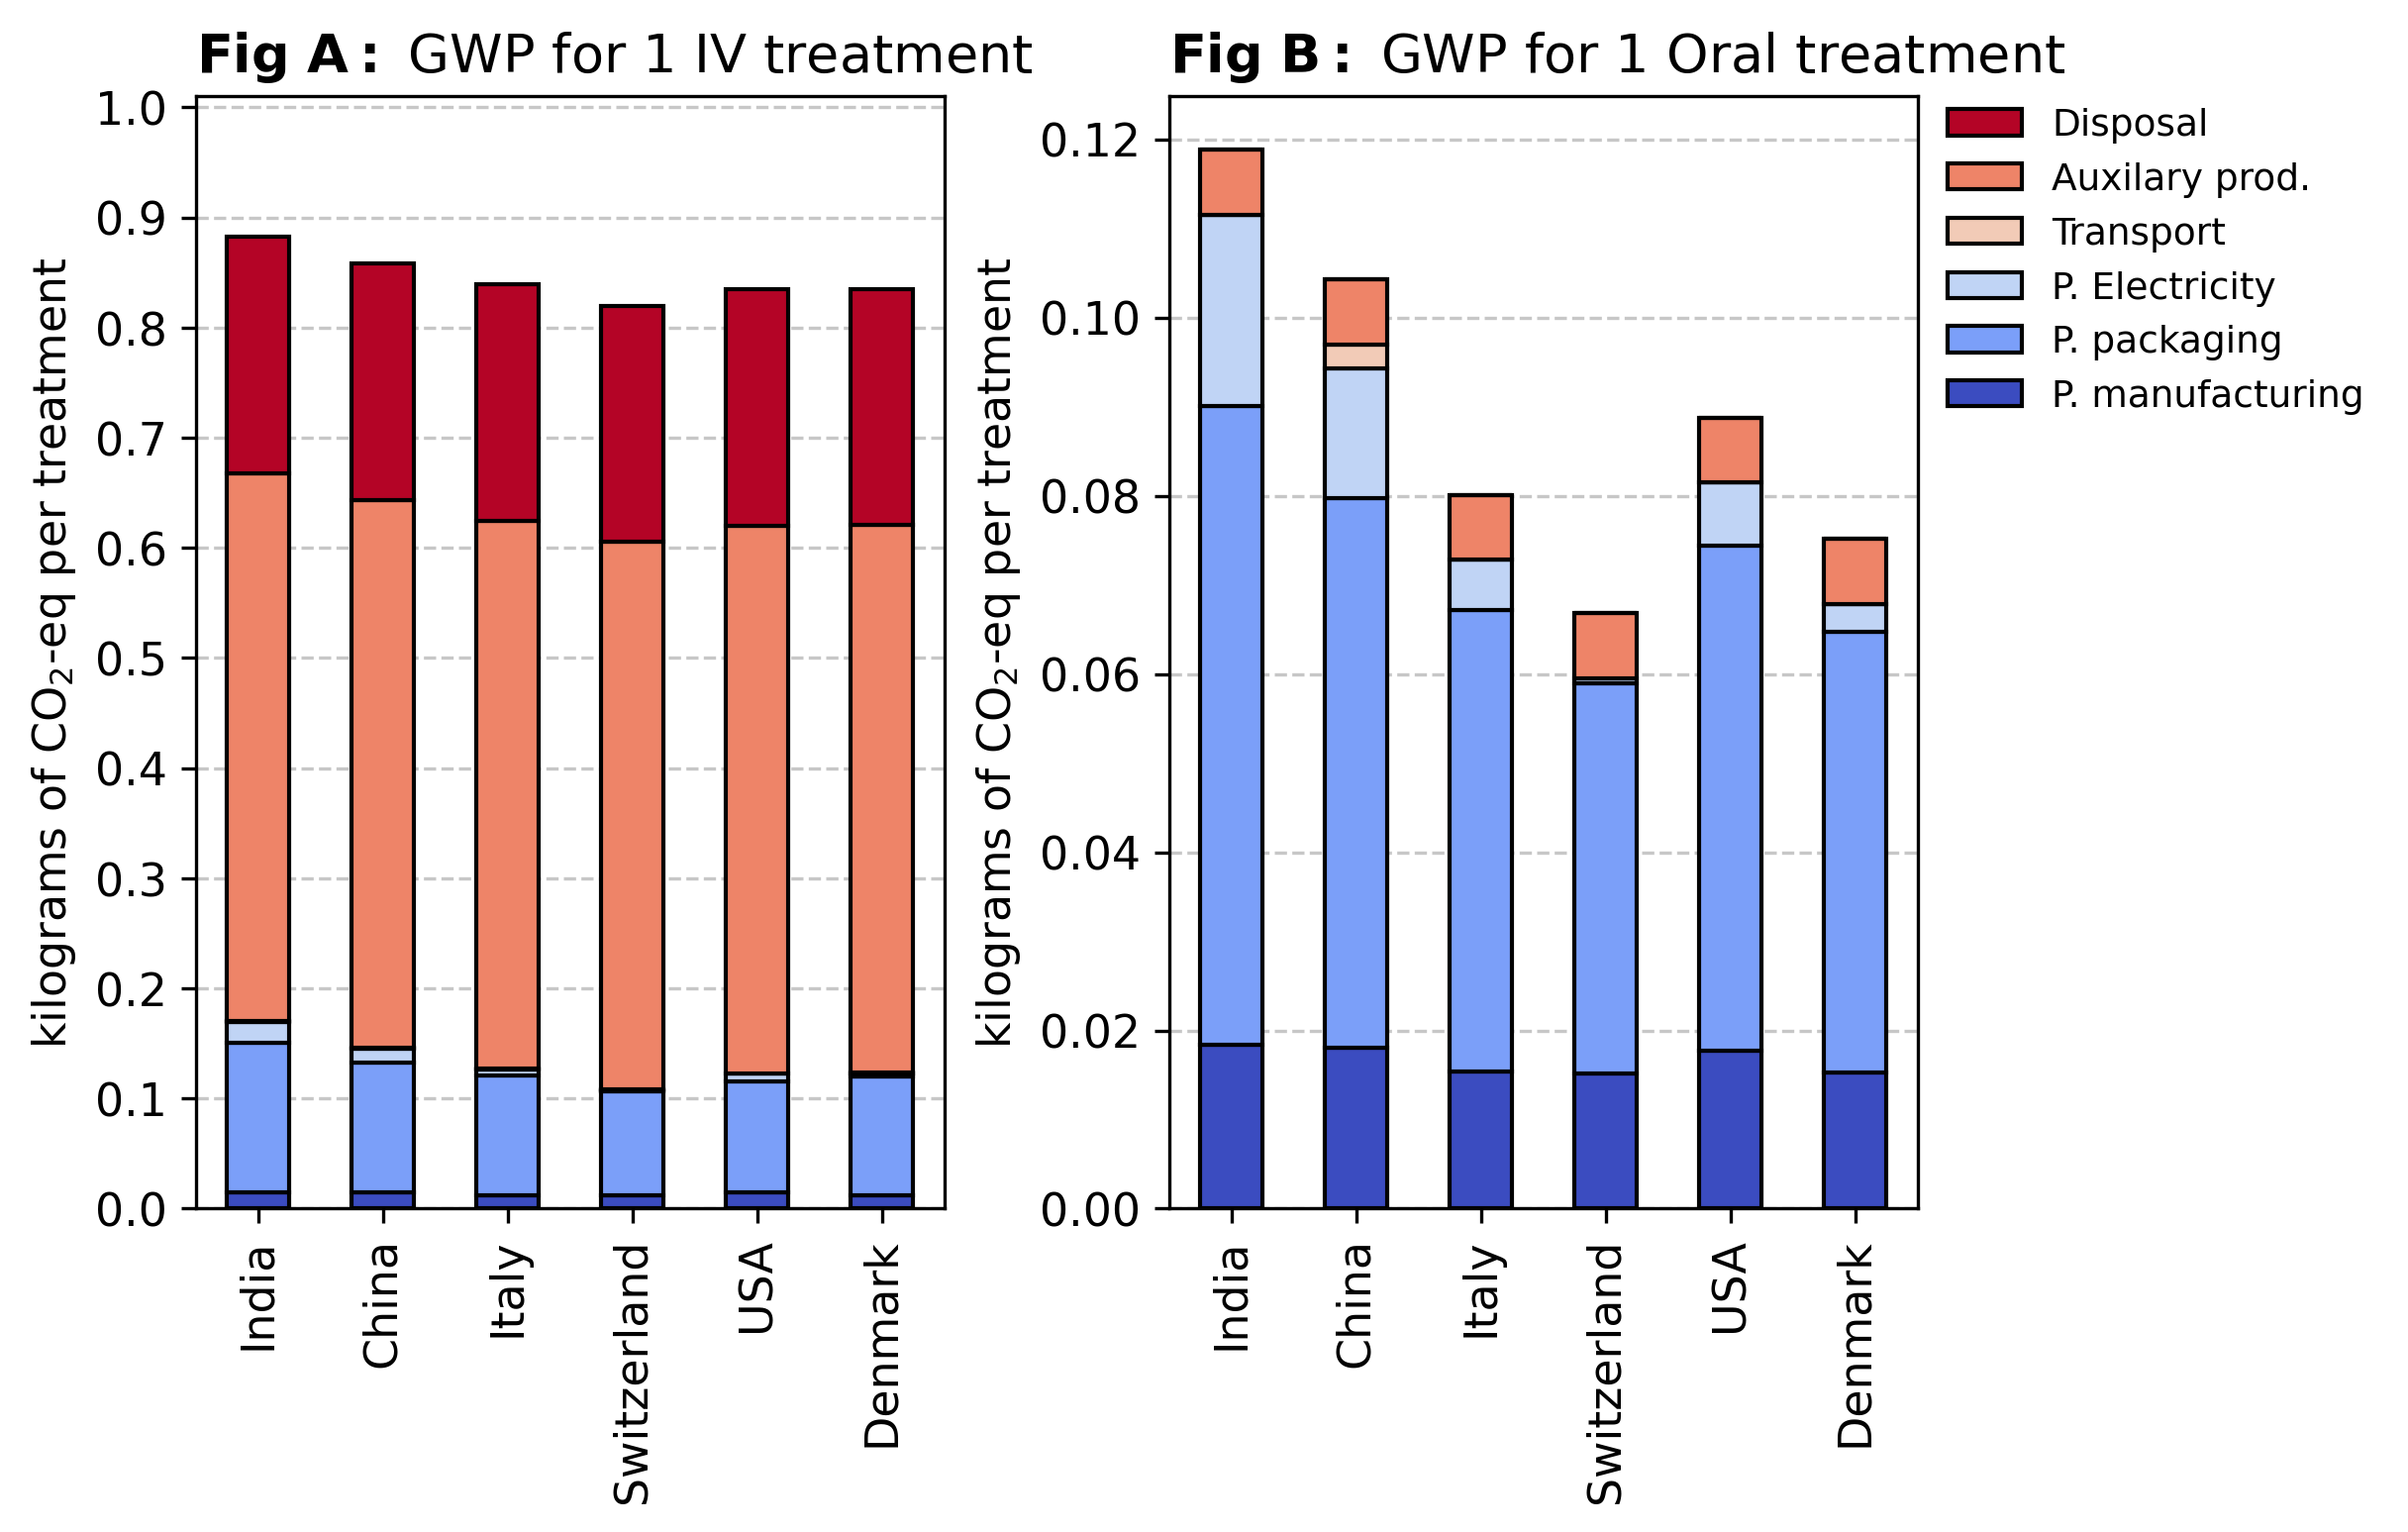

In [ ]:
colors = init.color_range(colorname="coolwarm", color_quantity=len(df_cat.index))
width_in, height_in, dpi = init.plot_dimensions()
fig, axes = plt.subplots(1, 2, figsize=(width_in, height_in), dpi=dpi)
plt.subplots_adjust(wspace=0.3)
title_identifier = [r"$\bf{Fig\ A:}$", r"$\bf{Fig\ B:}$"]

for p, df in enumerate(dct_sens_coutries.values()):
    df.T.plot(
                kind='bar',
                stacked=True,
                title="",
                color=colors,
                ax=axes[p],
                width=0.6,
                edgecolor="k",
                zorder=10
            )
    axes[p].set_title(f"{title_identifier[p]} GWP for 1 {stc.penicillin_G_V_to_IV_oral(pen_type[p])} treatment", loc="left")
    axes[p].set_xticklabels(list(country_order.values()), rotation=90)
    axes[p].grid(axis='y', linestyle='--', alpha=0.7, zorder=-0)
    stc.set_y_ticks(p, axes[p])
    axes[p].set_ylabel('kilograms of CO$_2$-eq per treatment')
    if p == 1:
        leg_color, _ = fig.gca().get_legend_handles_labels()
        leg_txt = list(df.index)
        leg_txt = leg_txt[::-1]
        leg_color = leg_color[::-1]
        axes[p].legend(
            leg_color,
            leg_txt,
            loc='upper left',
            bbox_to_anchor=(0.995, 1.02),
            ncol=1,
            frameon=False
            )
    else:
        axes[p].get_legend().remove()